# Week 7 Exercises


## Exercise 1: Convolution and Pooling
In this exercise we will see if we can get a better grasp of convolution and pooling.
Your job is to implement basic convolution and pooling.

For this we need the python package pillow  which you need to install

- The Convolution operator that takes a $d \times d$ weight matrix and 1 channel image, and applies the convolution with the weight vector with the image.
- The max pooling operator takes an input image and a max pooling size and returns the pooled output.
    For simplicity we only consider 2 x 2 max pooling
- Test your convolution implementation with the $3 \times 3$ matrix with -1 everywhere exept the middle and 8 in the middle is a classic edge detector pattern.
- Test your pooling implementation by applying a $2 \times 2$ max pooling to the output of the convolution.

We assume that we pad the input to ensure the output of the convolution is the same width and height as the input image.

To compare your implementation we have supplied code that applies the convolution and the pooling operator from the neural net package in pytorch.





image shape (512, 512)


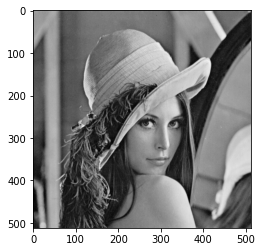

-499.0
-230.0


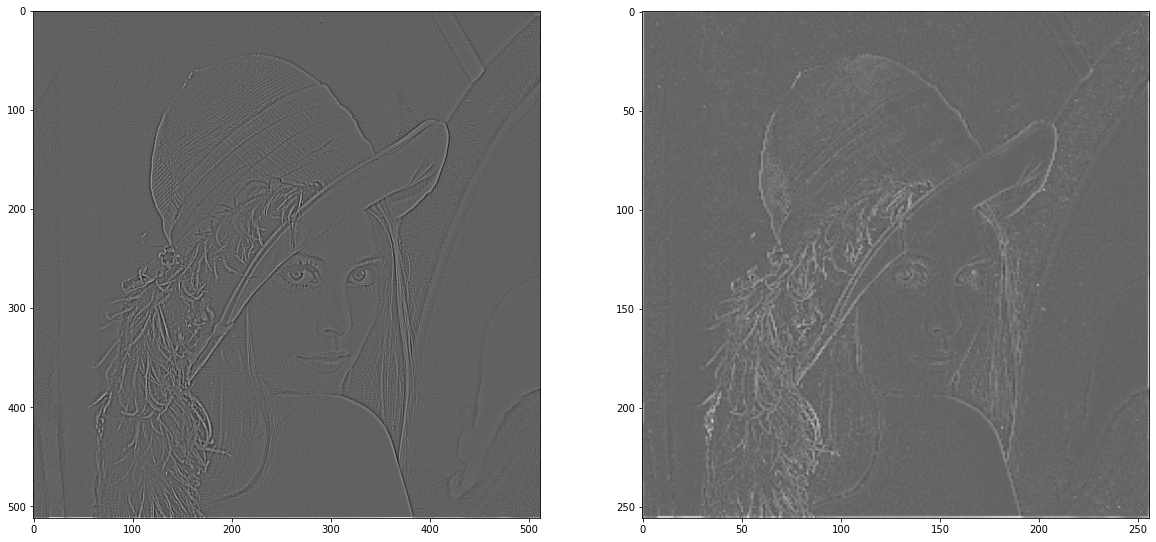

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image #(pacakge name is pillow - i.e. pip3 install pillow )
import os
filename = 'lena512_gray.bmp'

img = Image.open('lena512_gray.bmp')
lena = np.array(img)
print('image shape', lena.shape)
plt.imshow(lena, cmap='gray')
plt.show()

def conv2d(img, w):
    """ Return the result of applying the convolution defined by w to img - 
    for simplicity assume that w is square"""
    w_dim = w.shape[0]
    pad = w_dim - 2
    padded_img = np.pad(img, [pad, pad], 'constant', constant_values=0)    
    out = np.zeros(img.shape)
    ### YOUR CODE HERE
    height = img.shape[0]
    width = img.shape[1]
    for i in range(height):
        for j in range(width):
            tmp =  padded_img[i: i + w_dim,j:j + w_dim]
            out[i][j] = (tmp * w).sum()
    
        
    ### END CODE
    return out

def max_pool2d(img):
    """ Return the result of applying the 2 x 2 max pooling operator to mig (halve the width and height of image)"""
    out = np.zeros((int(img.shape[0]/2), int(img.shape[1]/2)))
    ### YOUR CODE HERE
    height = out.shape[0]
    width = out.shape[1]
    for i in range(height):
        for j in range(width):
            tmp =  img[2*i: 2*i + 2,2*j:2*j + 2]
            out[i][j] = tmp.max()
    ### END CODE
    return out

conv_filter = np.array([[-1., -1., -1.], [-1., 8, -1.], [-1., -1., -1.]])
convoluted_lena = conv2d(lena, conv_filter)
pooled_lena = max_pool2d(convoluted_lena)
print(convoluted_lena.min())
print(pooled_lena.min())
fig, axes = plt.subplots(1, 2, figsize=(20, 16))
axes[0].imshow(convoluted_lena, cmap='gray', vmin=convoluted_lena.min(), vmax=convoluted_lena.max())
axes[1].imshow(pooled_lena, cmap='gray', vmin=convoluted_lena.min(), vmax=convoluted_lena.max())
plt.show()

image shape torch.Size([1, 1, 512, 512])
convoluted_lena shape torch.Size([1, 1, 512, 512])
conv diff norm 0.0
pool diff norm 0.0


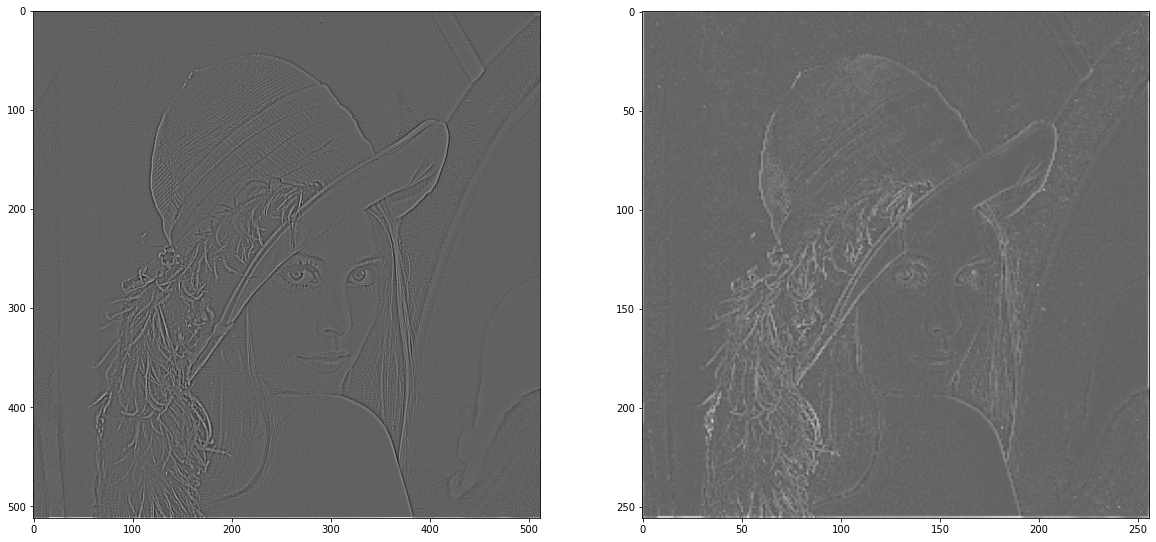

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch_lena = torch.from_numpy(lena).view(1, 1, lena.shape[0], lena.shape[1]).double()
print('image shape', torch_lena.shape)
tv = torch.tensor([[-1., -1., -1.], [-1., 8, -1.], [-1., -1., -1.]])
tv = tv.view(1, 1, 3, 3).double()
torch_convoluted_lena = F.conv2d(torch_lena, tv, torch.tensor([0.], dtype=torch.double), 1, 1, 1, 1)
print('convoluted_lena shape', torch_convoluted_lena.shape)
print('conv diff norm', np.linalg.norm(torch_convoluted_lena.numpy().squeeze() - convoluted_lena))
torch_pooled_lena = F.max_pool2d(torch_convoluted_lena, kernel_size=(2, 2))
print('pool diff norm', np.linalg.norm(torch_pooled_lena.numpy().squeeze() - pooled_lena))
fig, axes = plt.subplots(1, 2, figsize=(20, 16))
axes[0].imshow(torch_convoluted_lena.numpy().squeeze(), cmap='gray', vmin=torch_convoluted_lena.min(), vmax=torch_convoluted_lena.max())
axes[1].imshow(torch_pooled_lena.numpy().squeeze(), cmap='gray', vmin=torch_convoluted_lena.min(), vmax=torch_convoluted_lena.max())
plt.show()

# Exercise 2: How Many Parameters Does the VGG net use
The VGG net is a well known neural net architecture for image recognition. 

**How many parameters does it use? Write down a formula and compute the number!**

It has the following architecture [https://pytorch.org/docs/0.4.0/_modules/torchvision/models/vgg.html]

It takes as input an image of size 224 x 224 x 3.

First it computes 64, 3 x 3 x 3 convolutions i.e. makes 64 channels. Then it makes 64, 3 x 3 x 64 convolutionas on the output of the previous convolution i.e. it makes 64 new channels. This is followd by  a $2 \times 2$ max pooling operation.

The pattern continues as described below: A number is the number of new convolutions made on previous input and 'M' means max pooling.

64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'

All convolutions are 3x3 using padding of 1 of zeros around the input so the convolution output size has height and width the same as the input.
All poolings are $2 \times 2$ non-overlapping (stride=2)

After the fully convolutional layers it used standard fully connected layers as
- 512 * 7 * 7, 4096 (why 512 * 7 * 7?)
- 4096, 4096,
- 4096, 1000
        
### solution math
The number of parameters in the convolution layers is:
$$
64 \cdot 27 + 64 \cdot  9 \cdot 64 + 128 \cdot 9 \cdot 64 + 128 \cdot 9 \cdot 128 + 256 \cdot 9 \cdot 128 + 3 \cdot 256 \cdot 9 \cdot 256 + 512 \cdot 9 \cdot 256 + 7 \cdot 512 \cdot 9 \cdot 512
$$
After the convolutions, the size of the image has gone down by 5 max-poolings, so it becomes:
$$
224/2 = 112, 112/2 = 56, 56/2 = 28, 28/2 = 14, 14/2 = 7.
$$
The number of parameters in the fully connected layers is thus:
$$
512 \cdot 7 \cdot 7 \cdot 4096 + 4096^2 + 4096 \cdot 1000
$$
Summing it all gives 143.651.392 parameters
### end solution



## Ex 3:  Bias Variance 

-   Does Bias and Variance terms (two numbers) in the Bias Variance
    decomposition depend on the learning algorithm.

-   What is Variance (in Bias Variance tradoff) if we have a hypothesis
    set of size $1$ namely the constant model $h(x) = 2$. The learning
    algorithm always picks this hypothesis no matter the data.

-   What is the Variance (in the Bias Variance tradeoff) if the simple
    hypothesis from the previous question is replaced by a very very
    sophisticated hypothesis.

-   Assume the target function is a second degree polynomial, and the
    input to your algorithm is always eleven distinct (noiseless) points. Your
    hypothesis set is the set of all degreee 10 polynomial and the
    learning algorithm returns the hypothesis with the best fit
    (miniming least squared error) given the data. What is Bias and what
    is Variance?

## SOLUTION MATH
- yes
- 0
- 0
- 0, 0

## END SOLUTION

## Ex 4: Bias Variance - Hard Exercise
Book Problem 2.24 part (a)

Short Version:
   
  - The target function is $f(x) = x^2$ and the cost is Least Squares.

  - Sample two points $x_1, x_2$ from $[-1, 1]$ uniformly at random to get the data set $D = \{(x_1, x_1^2), (x_2, x_2^2)\}$

  - Use hypothesis space $\{h(x) = ax +b\mid a,b\in\Bbb R\}$ i.e. lines. There are two parameters $a$ and $b$.

  - Given a data set $D = \{(x_1, x_1^2), (x_2, x_2^2)\}$ the algorithm returns the line that fits these points.

  - Your task is to write down an analytical expression for $\bar{g} = \mathbb{E}_D [h_D]$ where $h_D$ is the hypothesis learned on D.

**Step 1.** What is the in sample error of $h_D$ and why?

**Step 2.** Given $D$ what are $a, b$ (defined by the line between $(x_1, x_1^2)$ and  $(x_2, x_2^2)$)? Hint: $x_2^2- x_1^2 = (x_2-x_1)(x_2 + x_1)$.

**Step 3.** What is the expected value of the slope $a$ over $x_1$ and $x_2$?

**Step 4.** What is the expected value of the intercerpt $b$ over $x_1$ and $x_2$? 



## SOLUTION MATH
check for sign issues
1. it is zero because a line fits two points
2. $a = (x_2^2 - x_1^2)/(x_2-x_1) =  x_1+x_2$,
    $b = x_2^2 - a x_2 = x_1^2 - a x_1$, b is start from point $(x_1, x_1^2)$ and walk $x_1$ back to zero with slope $a$
3. 0 since $\mathbb{E}[x_1 +x_2] = \mathbb{E}[x_1] + \mathbb{E}[x_2] = 2\int_{-1}^{1} x \,dx =  0$.
4. 
$$
\mathbb{E}[x_2^2 - a x_2] = \mathbb{E}[x_2^2] - \mathbb{E}[a x_2] = \mathbb{E}[x_2^2] - \mathbb{E}[(x_1+x_2) x_2] = \mathbb{E}[x_2^2] - \mathbb{E}[(x_1+x_2) x_2]  = \mathbb{E}[x_2^2] - \mathbb{E}[x_2 x_2)] - \mathbb{E}[x_1 x_2)] 
= \mathbb{E}[x_1 x_2)] = \mathbb{E}[x_1] \mathbb{E}[x_2]  = 0
$$
since $x_1$ and $x_2$ are independent

## END SOLUTION

**More hints**
For the uniform distribution over $[-1,1]$ the mean is $0$ 

## Ex 5: Bias Variance Experiment 
In this exercise you must redo the experiment shown at the lectures.
This exercise takes up quite a lot of space so we have moved it to a separate notebook. Go to [BiasVariance Notebook](BiasVariance.ipynb)